### Домашнее задание TSML-9 №3

1. Выберите ряд из первого задания.
1. Постройте его модель ARIMA.
1. Оформите отчёт в Jupyter-ноутбук.

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def test_stationarity(name,timeseries):
    print(f'Results of Dickey-Fuller Test for {name}:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    return dftest[1]

In [4]:
def tsplot(y, name, lags=None,  figsize=(14, 8), style='bmh'):
    #test_stationarity(y)
    pval=test_stationarity(name,y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title(f'{name}')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return pval

In [5]:
#series_femalebirths = pd.read_csv("Series\daily-total-female-births-in-cal.csv")['Count'].dropna()
#series_airline = pd.read_csv("Series\international-airline-passengers.csv")['Count'].dropna()
series_temperature = pd.read_csv("Series\mean-monthly-air-temperature-deg.csv")['Deg'].dropna().reset_index(drop=True)
#series_robberies = pd.read_csv("Series\monthly-boston-armed-robberies-j.csv")['Count'].dropna()
#series_sales= pd.read_csv("Series\monthly-sales-of-company-x-jan-6.csv")['Count'].dropna()
#series_dowjones = pd.read_csv("Series\weekly-closings-of-the-dowjones-.csv")['Close'].dropna()
series_temperature.head()

0    40.6
1    40.8
2    44.4
3    46.7
4    54.1
Name: Deg, dtype: float64

In [6]:
lst_ser={#'series_femalebirths':series_femalebirths
#,'series_airline':series_airline
#,
'series_temperature':series_temperature 
#,'series_robberies':series_robberies,
#'series_sales':series_sales,
#'series_dowjones':series_dowjones,
#'series_femalebirths':series_femalebirths
}

Results of Dickey-Fuller Test for series_temperature:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


Гипотеза H0 о нестационарности series_temperature отвергается, так как (P-value == 1.70E-02) < 5%


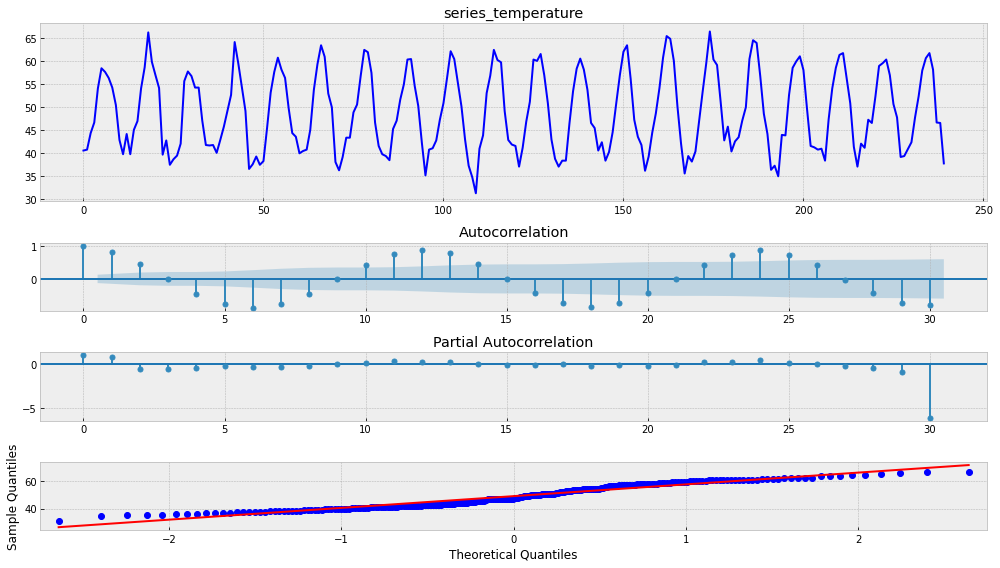

In [7]:
dct_ln={}
for k,ser in lst_ser.items():
    #ser_ln=np.log(ser)
    loc_p_v=tsplot(ser,k,lags=30)
    if(loc_p_v<0.05):
        dct_ln[k]=ser
        print(f'Гипотеза H0 о нестационарности {k} отвергается, так как (P-value =={loc_p_v : .2E}) < 5%')
    else:
        print(f'Гипотеза H0 о нестационарности {k} принимается, так как (P-value =={loc_p_v : .2E}) > 5%')


## ARIMA (p,d,q)

ARIMA - естественное расширение модели ARMA. Как мы уже хорошо знаем - многие временные ряды не стационарны, но они могут такими стать в результате операции дифференцирования. В модели ARIMA "дифференцирование" (в количестве d-раз) вносится в саму модель


$\delta^p y_t = c + \sum_{i=1}^p a_i \delta^d y_{t-i} + \sum_{j=1}^q b_j \epsilon_{t-j} + \epsilon_t$

In [8]:
series = lst_ser['series_temperature']

best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))



aic: 1147.19418 | order: (2, 1, 4)


In [9]:
best_mdl

Results of Dickey-Fuller Test for series_temperature:
Test Statistic                  -5.392484
p-value                          0.000004
#Lags Used                       9.000000
Number of Observations Used    229.000000
Critical Value (1%)             -3.459233
Critical Value (5%)             -2.874245
Critical Value (10%)            -2.573541
dtype: float64


3.512525483918979e-06

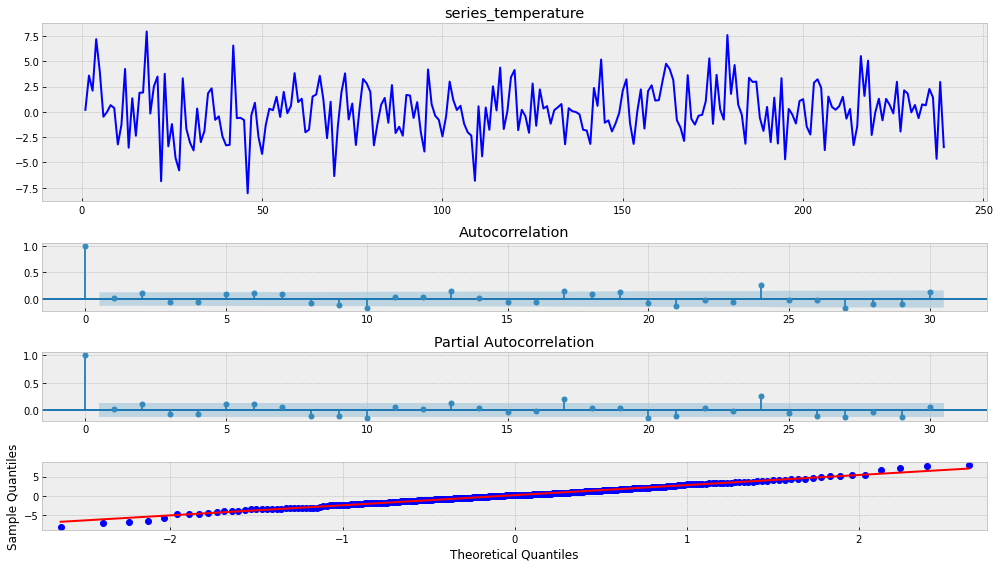

In [10]:
#tsplot(ser,k,lags=30)
tsplot(best_mdl.resid,'series_temperature',lags=30)

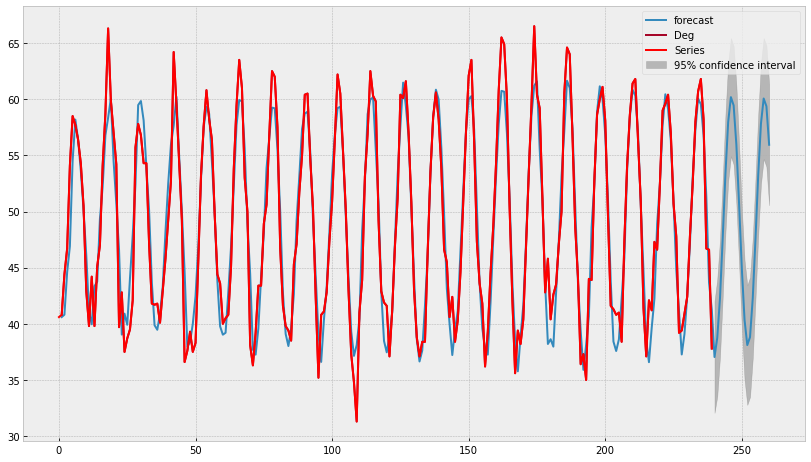

In [11]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(1, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()